In [ ]:
# make sure to set Notebook file root to "${workspaceFolder}" in vscode!
import requests
import pandas as pd
import numpy as np

from data_import.consumption_data import get_consumption_data
from collections import defaultdict
from matplotlib import pyplot as plt

#### Data import

In [9]:
response = requests.get("https://api.elhub.no/energy-data/v0/consumption-groups")
response.raise_for_status()

print([i["id"] for i in response.json()["data"]])

['household', 'cabin', 'primary', 'secondary', 'tertiary', 'industry', 'private', 'business', '*']


groups:
* Household:
    * Normal Homes
* Cabin
    * Cabins and secondary homes
* Primary Industry
    * Resource extraction
* Secondary Industry
    * Production
* Tertiary Industry
    * Services

Rest is combination groups (household + cabin etc)

In [3]:
consumption_df = get_consumption_data("NO5", start_year = 2021, end_year = 2026, save_path="./data/consumption_data.csv")

# sort usage by start time and consumption group
consumption_by_group = consumption_df.pivot_table(
    index="startTime",
    columns="consumptionGroup",
    values="quantityKwh"
    ).sort_index()

##### Visualization

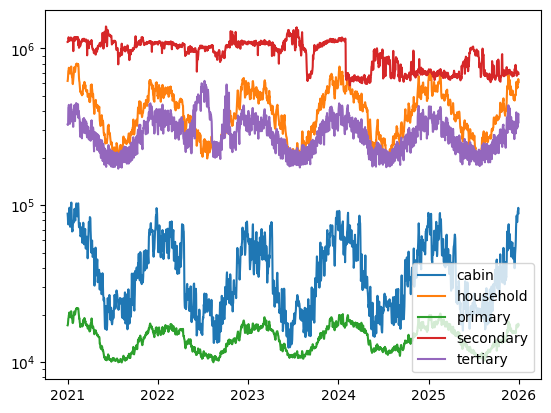

In [5]:
plt.plot(consumption_by_group.groupby(consumption_by_group.index.date).mean())
plt.legend(consumption_by_group.columns, loc="lower right")
plt.yscale('log') 
plt.show()

In [6]:
group_data = consumption_by_group.copy()
group_data["year"] = consumption_by_group.index.year
group_data["month"] = consumption_by_group.index.month
group_data["day"] = consumption_by_group.index.day
group_data["weekday"] = consumption_by_group.index.weekday
group_data["hour"] = consumption_by_group.index.hour

yearly_consumption_by_group = defaultdict(dict)
periods = ["month", "day", "hour", "weekday"]

for period in periods:
    for group in consumption_by_group.columns:
        yearly_consumption_by_group[period][group] = (
        group_data.pivot_table(
            index=periods,
            columns="year",
            values=group
        )
        .groupby(period)
        .mean()
    )

C:\Users\tobso\AppData\Local\Temp\ipykernel_27768\2717335852.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


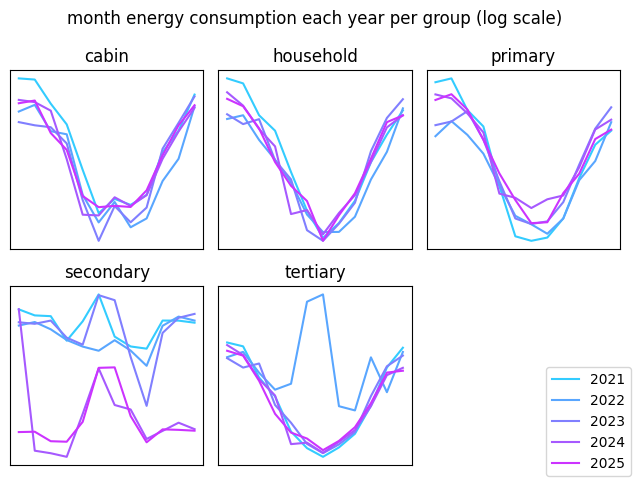

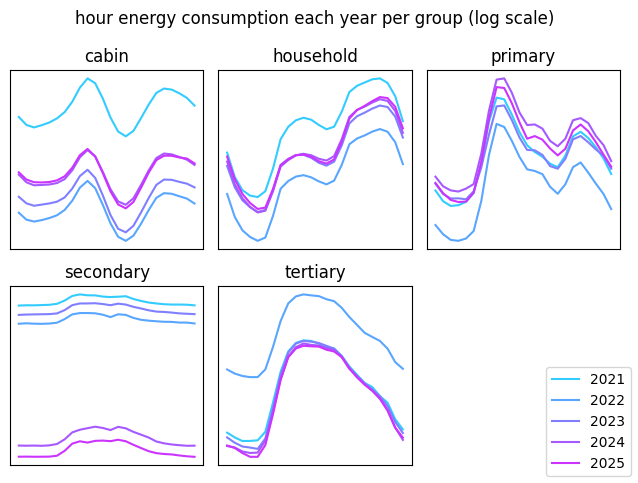

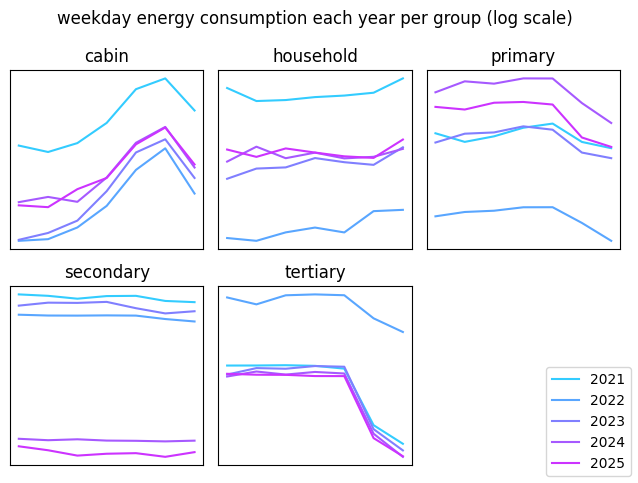

In [ ]:
for i, (period, groups) in enumerate(yearly_consumption_by_group.items()):
    if period == "day": # behaviours generally dont change by the day of month
        continue

    fig, ax = plt.subplots(nrows=2, ncols=3)    
    
    for j, (group, data) in enumerate(groups.items()):
        years = data.columns
        cmap = plt.cm.cool(np.linspace(0.2, 0.8, len(years)))
    
        for k, year in enumerate(years):
            ax[j//3, j%3].plot(data[year], color=cmap[k])
    
        ax[j//3, j%3].set_yscale("log")
        ax[j//3, j%3].yaxis.set_visible(False)
        ax[j//3, j%3].set_xticks([])
        ax[j//3, j%3].set_yticks([])
        ax[j//3, j%3].set_title(group)
    
    fig.delaxes(ax[1, 2])
    fig.legend(years, loc="lower right")
    fig.suptitle(f"{period} energy consumption each year per group (log scale)")
    fig.tight_layout()
    fig.show()

#### 1. Utvikling i strømforbruk
Hvordan har strømforbruket i **NO5** utviklet seg de siste årene blant de forskjellige forbrukergruppene?  
Har forbruksmønsteret endret seg siden 2021?

generelt har strømforbruket holdt seg relativt jevnt, men det er noen endringer/outliers.

1. I 2022 er det en rar outlier i service industrien på vestlandet. gjennom sommeren pleier det å gå i en bue, men i 2022 var den en svær økning gjennom sommeren og en till i oktober. jeg har et par teorier på hvorfor: (month energy consumption)
    * Det var en varm sommer, etter at norge hadde åpnet igjen etter covid. dette kan ha ført til mye turisme osv. pga det var varmt måtte mange service bedrifter kjøle ned med air condition.
    * Samme året var det ingen høydepunkt i produksjons industrien i sommeren. er det en bedrift/industri som er omkvalifisert til service i 2022 som ble re-kvalifisert som produksjon i 2023?

2. i januar 2024 skjer noe i produksjons industrien. energi forbruket faller ganske kraftig, og det har holdt seg lavt siden. jeg ser ingen andre industrier som har økt. derfor lurer jeg på om en bedrift har byttet over til meir effektive maskiner, eller slått ned? (month energy consumption)

3. generelt sett, har 2021 høyt strømforbruk av privat personer, mens 2022 har lavere enn normalt strømforbruk. (hour & weekday energy production)

4. hus har økt sakte men sikkert om man ser vekk fra 2021 hvor de fleste var hjemme grunnet covid (hour & weekday energy production)
5. hytter viser samme trend som samme som hus (hour & weekday energy production)
6. primær industri har økt sakte men sikkert gjennom årene (hour & weekday energy production)
7. service industrien har minsket sakte men sikkert (utenom 2022) (hour & weekday energy production)